In [11]:
from PIL import Image, ImageFile
import os
from matplotlib import pyplot as plt
import tifffile as tiff

In [17]:
def image_path(patient, img_type='all', type='train'):
    data_dir = os.getcwd() # 'datasets/acrobat'
    directory = os.path.join(data_dir, type, 'WSI')
    
    ER_path = os.path.join(directory, f'{patient}_ER_{type}.tif')
    HE_path = os.path.join(directory, f'{patient}_HE_{type}.tif')
    HER2_path = os.path.join(directory, f'{patient}_HER2_{type}.tif')
    KI67_path = os.path.join(directory, f'{patient}_KI67_{type}.tif')
    PGR_path = os.path.join(directory, f'{patient}_PGR_{type}.tif')
    paths = {}
    if os.path.exists(ER_path):
        paths['ER'] = ER_path
    if os.path.exists(HE_path):
        paths['HE'] = HE_path
    if os.path.exists(HER2_path):
        paths['HER2'] = HER2_path
    if os.path.exists(KI67_path):
        paths['KI67'] = KI67_path
    if os.path.exists(PGR_path):
        paths['PGR'] = PGR_path
    if img_type == 'all':
        return paths
    else:
        return paths[img_type]

In [18]:
patient = 40
paths = image_path(patient)

# Open the large TIFF file
for img_type, path in paths.items():
    with tiff.TiffFile(path) as tif:
        for page in tif.pages:
            print(f"[{img_type}]\tshape : {page.shape}, dtype: {page.dtype}")

In [19]:
# Load the image
def load_image(filepath, resolution='medium'):
    page=2 # medium resolution
    if resolution == 'low':
        page=-2
    elif resolution == 'high':
        page=0
    with tiff.TiffFile(filepath) as tif:
        image = tif.pages[page].asarray() 
    return image # (H, W, C)

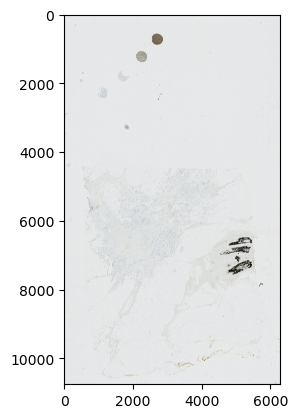

In [33]:
from scipy import ndimage
import numpy as np

patient = 105
type = 'train'
data_dir = os.getcwd() # 'datasets/acrobat'
directory = os.path.join(data_dir, '1')
filepath = os.path.join(directory, f'{patient}_HER2_{type}.tif')
img = load_image(filepath, 'medium')
img = np.flip(np.rot90(img), axis=0)
plt.imshow(img)


# Preprocess 
## 1. Crop the tissue part

In [13]:
import cv2
import numpy as np

# Function to check if a window contains tissue
def is_tissue_present(patch, threshold_value=200, min_tissue_ratio=0.05):

    # Convert the patch to grayscale
    gray_patch = cv2.cvtColor(patch, cv2.COLOR_RGB2GRAY)
    
    # Apply binary thresholding
    _, binary_patch = cv2.threshold(gray_patch, threshold_value, 255, cv2.THRESH_BINARY)
    
    # Calculate the percentage of non-white pixels (tissue)
    non_background_pixels = np.sum(binary_patch == 0)  # Count black pixels (tissue)
    total_pixels = patch.shape[0] * patch.shape[1]
    
    tissue_ratio = non_background_pixels / total_pixels
    
    return tissue_ratio > min_tissue_ratio

# Function to slide a window over the image
def sliding_window(image, window_size, step_size, padding=100):
    assert padding < image.shape[0] - window_size[1] -padding + 1 and padding < image.shape[1] - window_size[0] -padding + 1, f"Padding is too large : {padding} < {image.shape[0] - window_size[1] -padding + 1}, {padding} < {image.shape[1] - window_size[0] -padding + 1}"
    for y in range(padding, image.shape[0] - window_size[1] -padding + 1, step_size):
        for x in range(padding, image.shape[1] - window_size[0] -padding + 1, step_size):
            patch = image[y:y + window_size[1], x:x + window_size[0]]
            yield (x, y, patch)

# Function to find the bounding box of the tissue region
def find_tissue_bounding_box(image, window_size=(512, 512), step_size=256, threshold_value=200, min_tissue_ratio=0.05, padding=100):
    tissue_coords = []

    # Slide window over the image
    for (x, y, patch) in sliding_window(image, window_size, step_size, padding):
        if is_tissue_present(patch, threshold_value, min_tissue_ratio):
            tissue_coords.append((x, y, x + window_size[0], y + window_size[1]))

    if not tissue_coords:
        # print("No tissue found.")
        return None, None, None, None
    
    # Calculate the bounding box that covers all tissue regions
    x_min = min([x1 for (x1, y1, x2, y2) in tissue_coords])
    y_min = min([y1 for (x1, y1, x2, y2) in tissue_coords])
    x_max = max([x2 for (x1, y1, x2, y2) in tissue_coords])
    y_max = max([y2 for (x1, y1, x2, y2) in tissue_coords])

    return x_min, y_min, x_max - x_min, y_max - y_min

# Full process
def process_image(image, threshold_value=200, min_tissue_ratio='auto', padding=100):
    padding = max(padding, 1)
    if image.shape[0] < image.shape[1]:
        window_size = (image.shape[0]//2 - 2*padding, image.shape[0] - 2*padding) # (x, y)
        step_size = image.shape[0]//8
    else:
        window_size = (image.shape[1] - 2*padding, image.shape[1]//2 - 2*padding)
        step_size = image.shape[1]//8

    if min_tissue_ratio == 'auto': # Calculate min_tissue_ratio
        gray_patch = cv2.cvtColor(image[padding:-padding, padding:-padding, :], cv2.COLOR_RGB2GRAY)
        _, binary_patch = cv2.threshold(gray_patch, threshold_value, 255, cv2.THRESH_BINARY)
        non_background_pixels = np.sum(binary_patch == 0)  # Count black pixels (tissue)
        total_pixels = binary_patch.shape[0] * binary_patch.shape[1]
        min_tissue_ratio = non_background_pixels / total_pixels
        # print(f"Set min_tissue_ratio: {min_tissue_ratio}")

    x, y, w, h = find_tissue_bounding_box(image, window_size, step_size, threshold_value, min_tissue_ratio, padding)
    
    if x is None:
        while threshold_value > 0 and x is None:
            threshold_value -= 10
            min_tissue_ratio -= 0.01
            # print('threshold_value : ', threshold_value)
            x, y, w, h = find_tissue_bounding_box(image, window_size, step_size, threshold_value, min_tissue_ratio, padding)
    
    return (x, y, w, h)

In [14]:
# Function to crop the ROI
def crop_roi(image, x, y, w, h):
    return image[y:y+h, x:x+w]

In [ ]:
# Original image
img = load_image(image_path(92, 'HER2'))
plt.title("Original Image (x0.1 downsampled)")
plt.imshow(img[224*3:-224*3:10, 224*5:-224*5:10, :])

In [ ]:
from matplotlib.patches import Rectangle

# Draw a rectangle around the ROI on the original image
x, y, w, h = process_image(img, min_tissue_ratio='auto')
if x is not None:
    fig, ax = plt.subplots()
    ax.imshow(img[::10, ::10, :])
    rect = Rectangle((x//10, y//10), w//10, h//10, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.title("Original Image with ROI (x0.1 downsampled)")
    plt.show()

In [ ]:
# Processed image (tissue only)
x, y, w, h = process_image(img)
cropped_image = crop_roi(img, x, y, w, h)
if cropped_image is not None:
    plt.title("Cropped Tissue (x0.1 downsampled)")
    plt.imshow(cropped_image[::10, ::10, :])

## 2. Preprocess every image

In [11]:
def draw_bbox(image, x, y, w, h, title="Original Image with ROI"):
    fig, ax = plt.subplots()
    ax.imshow(image)
    rect = Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.title(title)
    plt.show()
    return

In [12]:
def draw_roi_for_patient(patient, resolution='medium', padding=100):
    paths = image_path(patient)
    num_images = len(paths)
    fig, axes = plt.subplots(1, num_images, figsize=(20, num_images))
    for ax, (img_type, path) in zip(axes, paths.items()):
        img = load_image(path, resolution)
        ax.imshow(img.copy())
        x, y, w, h = process_image(img, padding=padding)
        if x is not None:
            rect = Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        ax.set_title(f"{img_type} Image with ROI")
        # ax.axis('off')

    plt.tight_layout()
    plt.show()
    return 

In [ ]:
draw_roi_for_patient(42)

In [14]:
def crop_roi_for_patient(patient, resolution='medium', padding=100, save=False):
    paths = image_path(patient)
    num_images = len(paths)
    fig, axes = plt.subplots(1, num_images, figsize=(20, num_images))
    save_to = os.path.join(os.path.dirname(list(paths.values())[0]), 'roi')
    if not os.path.exists(save_to):
        os.makedirs(save_to)
    for ax, (img_type, path) in zip(axes, paths.items()):
        img = load_image(path, resolution)
        x, y, w, h = process_image(img, padding=padding)
        if x is not None:
            roi = crop_roi(img, x, y, w, h)
            if save:
                Image.fromarray(roi).save(os.path.join(save_to, f'{patient}_{img_type}_ROI.png'))
            ax.imshow(roi)
        ax.set_title(f"Cropped {img_type} Image")
        # ax.axis('off')

    plt.tight_layout()
    plt.show()
    return

In [ ]:
crop_roi_for_patient(42, save=True)

In [ ]:
for patient in range(0, 147, 10):
    print(f"Patient {patient}")
    draw_roi_for_patient(patient, padding=300)

## Place WSI files  as `WSI\[DATASET_NAME]\[CATEGORY_NAME]\[SLIDE_FOLDER_NAME] (optional)\SLIDE_NAME.tif`

### Move to **Random** class

In [1]:
import shutil
import os

base_dir = 'train/WSI'
for file in os.listdir(base_dir):
    if file.endswith('.tif'):
        patient = file.split('_')[0]
        random_class = int(patient)%4
        # move the file to WSI/acrobat/random_class
        destination_dir = os.path.join(base_dir, 'acrobat', str(random_class))
        os.makedirs(destination_dir, exist_ok=True)
        shutil.move(os.path.join(base_dir, file), os.path.join(destination_dir, file))
        print(f"Move {file} to {destination_dir}")

Move 306_ER_train.tif to train/WSI/acrobat/2
Move 723_ER_train.tif to train/WSI/acrobat/3
Move 591_PGR_train.tif to train/WSI/acrobat/3
Move 469_HE_train.tif to train/WSI/acrobat/1
Move 210_KI67_train.tif to train/WSI/acrobat/2
Move 435_HER2_train.tif to train/WSI/acrobat/3
Move 189_ER_train.tif to train/WSI/acrobat/1
Move 27_HER2_train.tif to train/WSI/acrobat/3
Move 136_KI67_train.tif to train/WSI/acrobat/0
Move 206_ER_train.tif to train/WSI/acrobat/2
Move 660_HE_train.tif to train/WSI/acrobat/0
Move 264_HE_train.tif to train/WSI/acrobat/0
Move 708_KI67_train.tif to train/WSI/acrobat/0
Move 418_HER2_train.tif to train/WSI/acrobat/2
Move 313_HER2_train.tif to train/WSI/acrobat/1
Move 82_KI67_train.tif to train/WSI/acrobat/2
Move 578_HE_train.tif to train/WSI/acrobat/2
Move 283_ER_train.tif to train/WSI/acrobat/3
Move 701_HE_train.tif to train/WSI/acrobat/1
Move 351_ER_train.tif to train/WSI/acrobat/3
Move 413_ER_train.tif to train/WSI/acrobat/1
Move 597_HE_train.tif to train/WSI/acrob

In [3]:
from collections import Counter

# Count the number of files for each label in the 'train' dataset
label_dict = {'train': {}, 'valid': {}, 'test': {}}
label_counts = Counter(label_dict['train'].values())

# Print the counts
print(f"Label 0: {label_counts['neg']} files")
print(f"Label 1: {label_counts['1']} files")
print(f"Label 2: {label_counts['2']} files")
print(f"Label 3: {label_counts['3']} files")

Label 0: 0 files
Label 1: 0 files
Label 2: 0 files
Label 3: 0 files


In [6]:
import os
label_folders = ['neg', '1', '2', '3']
current_dir = os.getcwd()
pyramid_dir = os.path.join(current_dir, 'pyramid_train')

folder_counts = {}
for label in label_folders:
    label_dir = os.path.join(pyramid_dir, label)
    if os.path.exists(label_dir):
        folder_counts[label] = len([name for name in os.listdir(label_dir) if os.path.isdir(os.path.join(label_dir, name))])
    else:
        folder_counts[label] = 0

print(folder_counts, sum(folder_counts.values()))

{'neg': 88, '1': 241, '2': 114, '3': 35} 478


In [10]:
print(os.path.join(current_dir, 'neg', '21_HER2_train.tif'))
os.path.exists(os.path.join(current_dir, 'neg', '21_HER2_train.tif'))

/data3/shcho/bci_ai/datasets/acrobat/neg/21_HER2_train.tif


True